### This code:
        1. imports REMA tiles, calculates the drainage basins and depression depths
        2. import Landsat 8 images that overlap the REMA tiles, and extracts surface lake boundaries
        3. Combines these two products and calculates the percentage of lakes observed in optical imagery vs. predicted from REMA 

In [81]:
from dask.distributed import Client
from dask.diagnostics import ProgressBar
import numpy as np
import xarray as xr
import pandas as pd
import hvplot.xarray
from matplotlib import widgets
from matplotlib import pyplot as plt
from rasterio import RasterioIOError
from tqdm.autonotebook import tqdm
%matplotlib inline
import skimage.morphology
import skimage.segmentation
#import richdem as rd
import scipy.ndimage
import dask
import math
import scipy.sparse

from matplotlib import widgets

import dask.array as da

from skimage import data, io

import cartopy.crs as ccrs

In [73]:
conda install ipympl

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.10
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /srv/conda/envs/notebook

  added / updated specs:
    - ipympl


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py37hc8dfbb8_0         151 KB  conda-forge
    ipympl-0.5.6               |     pyh9f0ad1d_1         231 KB  conda-forge
    libedit-3.1.20191231       |       h46ee950_0         187 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    python_abi-3.7             |          1_cp37m           4 KB  conda-forge
    ------------------------------------------------------------
                

from dask_kubernetes import KubeCluster

pip install dask_image

cluster = KubeCluster.from_yaml('workers-spec.yaml')
cluster.scale(10)  # specify number of workers explicitly

cluster.adapt(minimum=1, maximum=100)  # or dynamically scale based on current workload

# Part 1: REMA DEM drainage basins

## Import REMA tile from google bucket

In [2]:
uri_fmt = 'https://storage.googleapis.com/pangeo-pgc/8m/{i_idx:02d}_{j_idx:02d}/{i_idx:02d}_{j_idx:02d}_8m_dem_COG_LZW.tif'

chunksize = 8 * 512
rows = []
for i in tqdm(range(38, 36, -1)): #this tile range is Amery Ice Shelf
    cols = []
    for j in range(47, 53):
        uri = uri_fmt.format(i_idx=i, j_idx=j)
        try:
            dset = xr.open_rasterio(uri, chunks=chunksize)
            dset_masked = dset.where(dset > 0.0)
            cols.append(dset_masked)
            #print(uri)
        except RasterioIOError:
            pass
    rows.append(cols)

In [3]:
dsets_rows = [xr.concat(row, 'x') for row in rows]
ds = xr.concat(dsets_rows, 'y', )
ds.data

,Array,Chunk
Bytes,7.50 GB,67.11 MB
Shape,"(1, 25000, 75000)","(1, 4096, 4096)"
Count,972 Tasks,192 Chunks
Type,float32,numpy.ndarray


In [4]:
ds_array = ds.squeeze()
ds_array.data

dask.array<getitem, shape=(25000, 75000), dtype=float32, chunksize=(4096, 4096), chunktype=numpy.ndarray>

In [28]:
ds_array_rs = ds_array.coarsen(x=40,y=40).mean()


In [29]:

ds_subset  = ds_array_rs[150:250,300:600]


### The following is a number of functions translated from Matlab's TopoToolbox to calculate drainage catchements from a DEM:

In [30]:
def identifyflats(dem):
    # handle NaNs
    log_nans = np.isnan(dem);
    if np.any(log_nans):
        flag_nans = 1;
        dem = dask.array.nan_to_num(ds_subset, nan=-np.inf) 
    else:
        flag_nans = 0;
        dem = dem
        
     
    nhood = np.ones((3,3))
    # identify flats
    # flats: logical matrix with true where cells don't have lower neighbors
    flats = skimage.morphology.erosion(image=dem,selem=nhood) == dem;
    #remove flats at the border
    #flats[0:-1,[1, -1]]  = 0;
    #flats[[0 -1],0:-1]  = 0;
    #flats = skimage.segmentation.clear_border(flats, buffer_size=2)
    
    if flag_nans==1:
        # remove flat pixels bordering to nans
        flats[skimage.morphology.dilation(image=log_nans,selem = nhood)] = 0;


    # identify sills
    # find sills and set marker
    Imr = -np.inf * np.ones(dem.shape);
    Imr[flats] = dem[flats];
    Imr = (skimage.morphology.dilation(image=Imr,selem=nhood) == dem) & np.logical_not(flats);
    
    if flag_nans==1:
        Imr[log_nans] = 0;
        
    sills = Imr

    # identify interior basins
  
    interiorbasins = skimage.morphology.local_minima(dem);

    if flag_nans==1:
        interiorbasins = np.bitwise_or(interiorbasins,log_nans);
        interiorbasins = skimage.segmentation.clear_border(interiorbasins);
        interiorbasins[log_nans] = 0;
    else:
        interiorbasins = skimage.segmentation.clear_border(interiorbasins);

    return flats,sills,interiorbasins


In [31]:
import heapq
from imageio import imread


DIR_STRINGS = ["left", "down", "right", "up"]
DIRS = ((-1, 0), (0, -1), (1, 0), (0, 1))

def map_image_to_costs(D, PreSillPixel):
    """
    Read image data and convert it to a marginal cost function,
    a 2D array containing costs for moving through each pixel.
    This cost field forms the input for the weighted distance transform
    zero costs denote exits, infinite costs denote fully impenetrable obstacles.
    In this example, we follow Mercurial standards: obstacles are in black, exits in green,
    accessible space is in white, less accessible space has less white.
    Adapt to your own needs.
    :param image: String of image file or open file descriptor of image
    :return: 2D array representing the cost field
    """
    
    G = (D-np.min(D))/(np.max(D)-np.min(D))**-1
    if len(PreSillPixel)>0:
        for pair in PreSillPixel:
            PSPx = int(pair[0])
            PSPy = int(pair[1])

        #R = abs(D)*255/np.max(abs(D))

        G[PSPx,PSPy] = 1
        #B = abs(D)*255/np.max(abs(D)
    
    data = G*256
    # Exits are present in all green enough places ("G >> R and G")
    exits = np.where(data >= 255 )
    # Obstacles are in black (so at least G and B must be zero)
    obstacles = np.where(data < 1)
    # Convert image to greyscale
    grey_scales = data
    # Boolean index array for places without exits and obstacles
    space = np.ones(grey_scales.shape, dtype=np.bool)
    space[obstacles] = False
    space[exits] = False
    # Cost field: Inversely proportional to greyscale values
    cost_field = np.empty(data.shape)
    cost_field[obstacles] = np.inf
    cost_field[exits] = 0
    cost_field[space] = 1. / (grey_scales[space])
    return cost_field

def _wdt_python(cost_field):
    """
    See `get_weighted_distance_transform`
    :param cost_field: 2D array
    :return: Weighted distance transform array with same shape as `cost_field`
    """
    nx, ny = cost_field.shape
    # Cost for moving along horizontal lines
    costs_x = np.ones([nx + 1, ny], order='F') * np.inf
    costs_x[1:-1, :] = (cost_field[1:, :] + cost_field[:-1, :]) / 2
    # Cost for moving along vertical lines
    costs_y = np.ones([nx, ny + 1], order='F') * np.inf
    costs_y[:, 1:-1] = (cost_field[:, 1:] + cost_field[:, :-1]) / 2

    # Initialize locations (known/unknown/exit/obstacle)
    weighted_distance_transform = np.ones_like(cost_field, order='F') * np.inf
    exit_locs = np.where(cost_field == 0)
    obstacle_locs = np.where(cost_field == np.inf)
    weighted_distance_transform[exit_locs] = 0

    # Initialize Cell structures
    all_cells = {(i, j) for i in range(nx) for j in range(ny)}
    known_cells = {cell for cell in zip(exit_locs[0], exit_locs[1])}
    unknown_cells = all_cells - known_cells - {cell for cell in zip(obstacle_locs[0], obstacle_locs[1])}
    new_candidate_cells = set()
    for cell in known_cells:
        new_candidate_cells |= _get_new_candidate_cells(cell, unknown_cells)
    cand_heap = [(np.inf, cell) for cell in new_candidate_cells]
    # Loop until all unknown cells have a distance value
    if len(cand_heap)>0:
        while True:
            # by repeatedly looping over the new candidate cells
            for cell in new_candidate_cells:
                # Compute a distance for each cell based on its neighbour cells
                distance = _propagate_distance(cell, [costs_x, costs_y], weighted_distance_transform)
                # Store this value in the heap (for fast lookup)
                # Don't check whether we have the distance already in the heap; check on outcome
                heapq.heappush(cand_heap, (distance, cell))
            # See if the heap contains a good value and if so, add it to the field. If not, finish.
            # Since we can store multiple distance values for one cell, we might need to pop a couple of times
            while True:
                min_distance, best_cell = heapq.heappop(cand_heap)
                if weighted_distance_transform[best_cell] == np.inf:
                    # Got a good one: no assigned distance in wdt yet
                    break
                elif min_distance == np.inf:  # No more finite values; done
                    return weighted_distance_transform
            # Good value found, add to the wdt and
            weighted_distance_transform[best_cell] = min_distance
            unknown_cells.remove(best_cell)
            new_candidate_cells = _get_new_candidate_cells(best_cell, unknown_cells)
    else:
        weighted_distance_transform = scipy.ndimage.distance_transform_edt(cost_field)+1
        return weighted_distance_transform
    """
    Checks whether an index exists an array
    :param index: 2D index tuple
    :return: true if lower than tuple, false otherwise
    """
    return (0 <= index[0] < nx) and (0 <= index[1] < ny)
def _exists(index, nx, ny):
    """
    Checks whether an index exists an array
    :param index: 2D index tuple
    :return: true if lower than tuple, false otherwise
    """
    return (0 <= index[0] < nx) and (0 <= index[1] < ny)


def _get_new_candidate_cells(cell, unknown_cells):
    """
    Compute the new candidate cells (cells for which we have no definite distance value yet
    For more information on the algorithm: check fast marching method
    :param cell: tuple of index; a new cell that has been added to the distance field
    :param unknown_cells: set of tuples; all cells still unknown
    :return: Set of new candidate cells for which to compute the distance
    """
    new_candidate_cells = set()
    for direction in DIRS:
        nb_cell = (cell[0] + direction[0], cell[1] + direction[1])
        if nb_cell in unknown_cells:
            new_candidate_cells.add(nb_cell)
    return new_candidate_cells


def _propagate_distance(cell, costs, wdt_field):
    """
    Compute the weighted distance in a cell using costs and distances in other cells
    :param cell: tuple, index of a candidate cell
    :param costs: list of cost arrays in X and Y direction
    :param wdt_field: the weighted distance transform field up until now
    :return: a approximate distance based on the neighbour cells
    """
    nx, ny = wdt_field.shape
    # Find the minimal directions along a grid cell.
    # Assume left and below are best, then overwrite with right and up if they are better
    adjacent_distances = np.ones(4) * np.inf
    pots_from_axis = [0, 0]  # [x direction, y direction]
    costs_from_axis = [np.inf, np.inf]  #
    for i, dir_s in enumerate(DIR_STRINGS):
        # Direction for which we check the cost
        normal = DIRS[i]
        nb_cell = (cell[0] + normal[0], cell[1] + normal[1])
        if not _exists(nb_cell, nx, ny):
            continue
        pot = wdt_field[nb_cell]
        # distance in that neighbour field
        if dir_s == 'left':
            face_index = (nb_cell[0] + 1, nb_cell[1])
        elif dir_s == 'down':
            face_index = (nb_cell[0], nb_cell[1] + 1)
        else:
            face_index = nb_cell
        # Left/right is x, up/down is y
        cost = costs[i % 2][face_index]
        # Proposed cost along this direction
        adjacent_distances[i] = pot + cost
        # If it is cheaper to go from the opposite direction
        if adjacent_distances[i] < adjacent_distances[(i + 2) % 4]:
            pots_from_axis[i % 2] = pot
            costs_from_axis[i % 2] = cost
        hor_pot, ver_pot = pots_from_axis
        hor_cost, ver_cost = costs_from_axis
        # Coefficients of quadratic equation (upwind discretization)
    a = 1. / hor_cost ** 2 + 1. / ver_cost ** 2
    b = -2 * (hor_pot / hor_cost ** 2 + ver_pot / ver_cost ** 2)
    c = (hor_pot / hor_cost) ** 2 + (ver_pot / ver_cost) ** 2 - 1

    D = b ** 2 - 4 * a * c
    # Largest root represents upwind approximation
    x_high = (2 * c) / (-b - math.sqrt(D+0.001)) #edited to prevent divide by zero errors
    return x_high


In [54]:
def FlowObj(Z, cellsize):  
    nrc = Z.size
    [Iobj,SILLS,IntBasin] = identifyflats(Z);

    # Here we choose the distance transform from outside the lakes to the inside and take the locations as sills where the distance is maximum.
    DD = scipy.ndimage.distance_transform_edt(np.bitwise_not(IntBasin));
    MaxIntIX = [0,0] #added to prevent MaxIntIX does not exist errors
    IntBasin_labels = skimage.measure.label(IntBasin)
    for r in np.arange(0,np.max(IntBasin_labels)):
        PixelIdxList = np.argwhere(IntBasin_labels==r)
        ixm = np.argmax(DD[IntBasin_labels==r]);
        MaxIntIX = PixelIdxList[ixm];

        Iobj[PixelIdxList[0][0],PixelIdxList[0][1]] = 0;
        SILLS[PixelIdxList[0][0],PixelIdxList[0][1]] = 1;
    ixm = MaxIntIX;
    Iobj[ixm[0],ixm[1]] = 0;
    SILLS[ixm[0],ixm[1]] = 1;

    # establish the connectivity between sills and flats
    #dem = ZintoDB;
    whereSILLS = np.argwhere(SILLS);
    rows=[]
    cols=[]
    for rowcol in whereSILLS:    
        [row,col] = rowcol
        rows = np.append(rows,row)
        cols = np.append(cols,col)

    IXsill    = [rows,cols];
    rowadd = [-1, -1, 0, 1, 1,  1,  0, -1];
    coladd = [ 0,  1, 1, 1, 0, -1, -1, -1];
    PreSillPixel = [0]
    for r  in np.arange(0,8):
        rowp = rows + rowadd[r];
        colp = cols + coladd[r];

        ValidRowColPair1 = np.bitwise_and(rowp>0, colp>0)
        ValidRowColPair2 = np.bitwise_and(rowp<dem.shape[0], colp<dem.shape[1])
        ValidRowColPair  = np.bitwise_and(ValidRowColPair1, ValidRowColPair2) 
        whereValidRowColPair = np.where(ValidRowColPair)

        IXPreSill = [rowp[whereValidRowColPair],colp[whereValidRowColPair]];

        PreSillPixelCondition = (np.argwhere(np.bitwise_and((dem[np.int_(rows[whereValidRowColPair]), np.int_(cols[whereValidRowColPair])] == 
                    dem[np.int_(IXPreSill[0]),np.int_(IXPreSill[1])]),
                   Iobj[np.int_(IXPreSill[0]),np.int_(IXPreSill[1])]))
                                        )
        if np.count_nonzero(PreSillPixelCondition)>0:
            for i in  np.arange(0,len(PreSillPixelCondition)):
                PreSillPixelAddition = ([IXPreSill[0][PreSillPixelCondition[i].item()],IXPreSill[1][PreSillPixelCondition[i].item()]])
                PreSillPixel.append(PreSillPixelAddition)
        else:
            continue
    PreSillPixel.pop(0);
        

    Iobj  = np.bitwise_not(Iobj)    
    D = scipy.ndimage.distance_transform_edt(Iobj)
    if np.count_nonzero(np.bitwise_not(Iobj))<1:
        masked = -np.inf*np.ones(dem.shape,D.dtype); #Changed from inf to -inf
        masked[Iobj] = 0;
        D = (skimage.morphology.reconstruction(seed = (D+1),mask=masked,method='erosion') - D)*cellsize;
    else:
        masked = np.inf * np.ones(dem.shape,D.dtype); 
        masked[Iobj] = 0;
        D[np.bitwise_not(Iobj)]=np.inf
        D = ((skimage.morphology.reconstruction(seed = D+1,mask=masked,method='erosion'))- D) *cellsize
        D = np.nan_to_num(D)   

    D[Iobj] = np.inf
    D = D**-1
    cost_field  = map_image_to_costs(D,PreSillPixel)
    D = _wdt_python(cost_field) +1
    D[Iobj] = -np.inf;

    del PreSillPixel
    if np.any(np.isnan(np.diff(D.ravel()))):
        IXSortedFlats = np.arange(0,len(D.ravel()))
        IXSortedFlats = IXSortedFlats[::-1]
    else:
        IXSortedFlats = np.argsort(D.ravel());
        IXSortedFlats = IXSortedFlats[::-1]
    del D

    ndx = np.arange(np.uint32(0),np.uint32(nrc));
    ndx = ndx[IXSortedFlats];
    del IXSortedFlats

    ix = np.argsort(dem.ravel()[ndx]);
    ix = ix[::-1]
    ix = ndx[ix]
    del ndx

     # a fast solution that has quite much memory overhead...
    pp = np.zeros((dem.size),dtype=np.int32);
    IX = np.arange(np.int32(0),np.int32(dem.size));
    pp[ix] = IX;
    pp = pp.reshape(dem.shape)

    # cardinal neighbors
    IXC1 = skimage.morphology.dilation(pp, skimage.morphology.selem.diamond(1))
    IXC1 = IXC1.ravel()
    xxx1 = IXC1;
    IX   = IXC1[ix];
    IXC1 = ix[IX];
    G1   = (dem.ravel()[ix]-dem.ravel()[IXC1])/(cellsize);
    G1[ix == IXC1] = -np.inf;

     # diagonal neighbors
    kernel = np.array([[1,0,1],[0,1,0],[1,0,1]])
    IXC2 = skimage.morphology.dilation(pp,kernel);
    IXC2 = IXC2.ravel()
    xxx2 = IXC2;
    IX   = IXC2[ix];
    IXC2 = ix[IX];
    G2   = (dem.ravel()[ix]-dem.ravel()[IXC2])/np.linalg.norm([cellsize,cellsize]);


    # choose the steeper one
    I  = np.bitwise_and(G1<=G2, xxx2[ix]>xxx1[ix]);
    ixc = IXC1;
    ixc[I] = IXC2[I];

    I = ixc == ix;
    ix = ix[np.bitwise_not(I)];
    ixc = ixc[np.bitwise_not(I)];

    # remove nans
    I = np.isnan(dem.ravel());
    ixc = ixc[~I[ix]];
    ix = ix[~I[ix]];
    
    ix = np.int_(ix[~np.isnan(ix)])
    ixc = np.int_(ixc[~np.isnan(ixc)])

    return ix,ixc

In [55]:
def drainagebasins(dem,ix,ixc):
    DBcounter = 0;
    D = np.zeros(dem.size,dtype=np.int32);
    outlets=np.zeros((len(ix),1))
    for r in np.arange(len(ix)-1,1,-1):
        if D[ixc[r]] == 0:
            DBcounter = DBcounter+1;
            D[ixc[r]] = DBcounter;
            outlets[DBcounter] = ixc[r];

        D[ix[r]] = D[ixc[r]];

    D = D.reshape(dem.shape)

    outlets = np.double(outlets);
    return D,outlets

In [56]:
# Main function that calls the others
def HypsometryOfAllBasins(Z):

    #Calculate drainage  basins (using translated algorithm from TopoToolbox)
    [ix,ixc] = FlowObj(Z,cellArea)
    [DB, outlets] = drainagebasins(Z,ix,ixc)
    
    # Fill depressions in DEM
    Inan = np.isnan(Z)
    marker = -1*Z;
    II  = np.ones(Z.shape);
    II[:,0] = 0;
    II[:,-1]=0
    II[-1,:]=0
    II[0,:] = 0
    II = (np.bool_(II))
    marker[II]  = -1*np.inf;
    marker[Inan] = -1*np.inf;
    demfs  = -1*skimage.morphology.reconstruction(marker,-1*Z,'dilation');
    P_all = demfs-Z; #P_all = water accomodation space
    
    if np.count_nonzero((P_all>0))<1: #If no water accomadation  space  exists, DEM is filled
        DEMfilled=1
        print('DEM is filled')
        return
    
    #Build  data structure  on each drainage basin
    b_dict = {'BasinNumber','BasinArea','MaskLogical','MaskI','MaskXY','skip','Volume','maxdepth','hw','h'}
    b = pd.DataFrame(data={},columns=b_dict)
    num_basins = np.max(DB)
    for kk in np.arange(0,num_basins):
        BasinNumber = kk;
        Mask = DB == kk; 
        BasinArea = (np.sum(np.int_(Mask.ravel()))*cellArea); # basin area in m^2
        MaskLogical = Mask;
        MaskXY = np.where(Mask);  # mask for the basin
        MaskI= np.ravel_multi_index(MaskXY,Z.shape)
        depths = P_all[MaskXY] #Water accomodation space in drainage basin
        if np.count_nonzero(depths>0)<1: #If accomodation space is zero, i.e, no nonzero depths
            skip = 1;
            h = 0;
            maxdepth = 0;
            Volume = 0;
            hw = np.zeros(depths.size)
            #continue
        else:
            valid = np.argwhere(depths>=0)
            depths = depths[valid];
            heights = np.max(depths) - depths; #potential water height from bottom
            skip = 0;        
            Volume = (np.sum(depths.ravel())*cellArea);
            heights_sorted = np.sort(heights);
            while len(np.argwhere(np.diff(heights_sorted)==0))>0: #remove all identical pixels
                I = np.argwhere(np.diff(heights_sorted)==0);
                heights_sorted[I+1] = heights_sorted[I+1] +0.0001; # nudge the similar values up a tiny amount to avoid issues with the interpolation
            hw = heights_sorted;   # heights for hypsometry
            maxdepth = np.max(depths); # not actually the same as max(Heights) the smallest value of depths is not equal to zero
            h = 0;   # initial water depth is zero
        data={'BasinNumber':BasinNumber,
               'BasinArea':BasinArea,
               'MaskLogical':MaskLogical.ravel(),
               'MaskI':MaskI,
                'MaskXY': MaskXY,
               'skip':skip,
               'Volume':Volume,
               'maxdepth':maxdepth,
               'hw':hw,
               'h':h}
        DrainageBasin = pd.Series(data)
        b = b.append(DrainageBasin, ignore_index=True)
        BasinNumbers = np.unique(b.BasinNumber)
    return b, DB, P_all;

In [57]:
cellLength= np.float((ds_subset.x[2] - ds_subset.x[1]))

In [59]:
with ProgressBar():
    dem = ds_subset.values

[########################################] | 100% Completed |  1min 26.1s


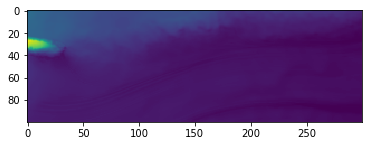

In [60]:
plt.imshow(dem)

In [61]:
with ProgressBar():
    ix, ixc = FlowObj(dem,40)
    

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in subtract
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in reciprocal
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater_equal
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/lib/function_base.py:1269: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


In [62]:
with ProgressBar():
    DB, outlet = drainagebasins(dem,ix,ixc)

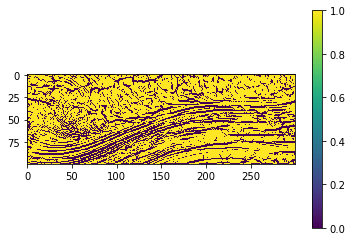

In [93]:
test = np.zeros(dem.ravel().shape)
test[ixc] = 1
plt.imshow(test.reshape(dem.shape))
plt.colorbar()

In [65]:
A = np.ones(dem.shape) #accumulation weight grid

A = A.ravel()
#Accumulation grid, No runoff input
for r in np.arange(0,len(ixc)):
    A[ixc[r]] = A[ix[r]]+A[ixc[r]];

A = A.reshape(dem.shape)
A  = A * cellLength**2

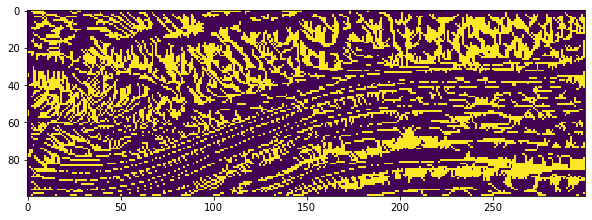

In [92]:
plt.figure(figsize=(10,10))
plt.imshow(A>5e5)


In [87]:
def drainagebasins_fromaccum(A,minarea):
    W = (A>minarea).ravel()
    Z = np.zeros(W.shape);
    Z[ix]  = W[ix];
    I = np.bool_(Z[ix]);
    Z[ixc[np.argwhere(I)]] = W[ixc[np.argwhere(I)]];
    W = np.int_(Z);

    I  = np.bool_(W[ix]);
    S_ix   = np.double(ix[np.argwhere(I)]);
    S_ixc  = np.double(ixc[np.argwhere(I)]);


    # recalculate stream indices
    IX = np.zeros(dem.ravel().shape);
    IX[np.bool_(W)]  = np.arange(0,np.count_nonzero(W));

    S_ix      = IX[S_ix.astype(int)];
    S_ixc     = IX[S_ixc.astype(int)];

    I = np.int_(np.argwhere((S_ixc)==0))

    S_ix[I] = np.nan;
    S_ixc[I] = np.nan;


    S_ix = np.int_(S_ix[~np.isnan(S_ix)])
    S_ixc = np.int_(S_ixc[~np.isnan(S_ixc)])

    IXgrid = np.argwhere(W)

    rows,cols = np.unravel_index(IXgrid, dem.shape)

    S_x = rows * 40
    S_y = cols * 40

    # Sparse matrix
    nrc = len(S_x);
    M  = scipy.sparse.coo_matrix((np.ones((len(S_ix))),(S_ix,S_ixc)),shape=(nrc,nrc));

    # Output logical array
    V = np.zeros((nrc,1));


    #outlets
    M1 = np.sum(M,axis=1)
    M2 = np.sum(M,axis=0).T
    for i in np.arange(0,nrc):
        V[i] = ((M1[i]==0) & (M2[i]!=0)) or V[i];

    V_ix  = np.argwhere(V.ravel());
    V_out = IXgrid[V_ix]

    D = np.zeros(dem.ravel().shape);
    val=0
    for i in np.arange(0,len(V_out)):
        D[V_out[i]] = val
        val=val+1

    for r in np.arange(len(ix)-1,0,-1):
        if np.logical_and(D[ixc[r]] != 0 , D[ix[r]]==0):
            D[ix[r]] = D[ixc[r]];
    DB = D.reshape(dem.shape)
    return DB

In [88]:
DB = drainagebasins_fromaccum(A,2e5)

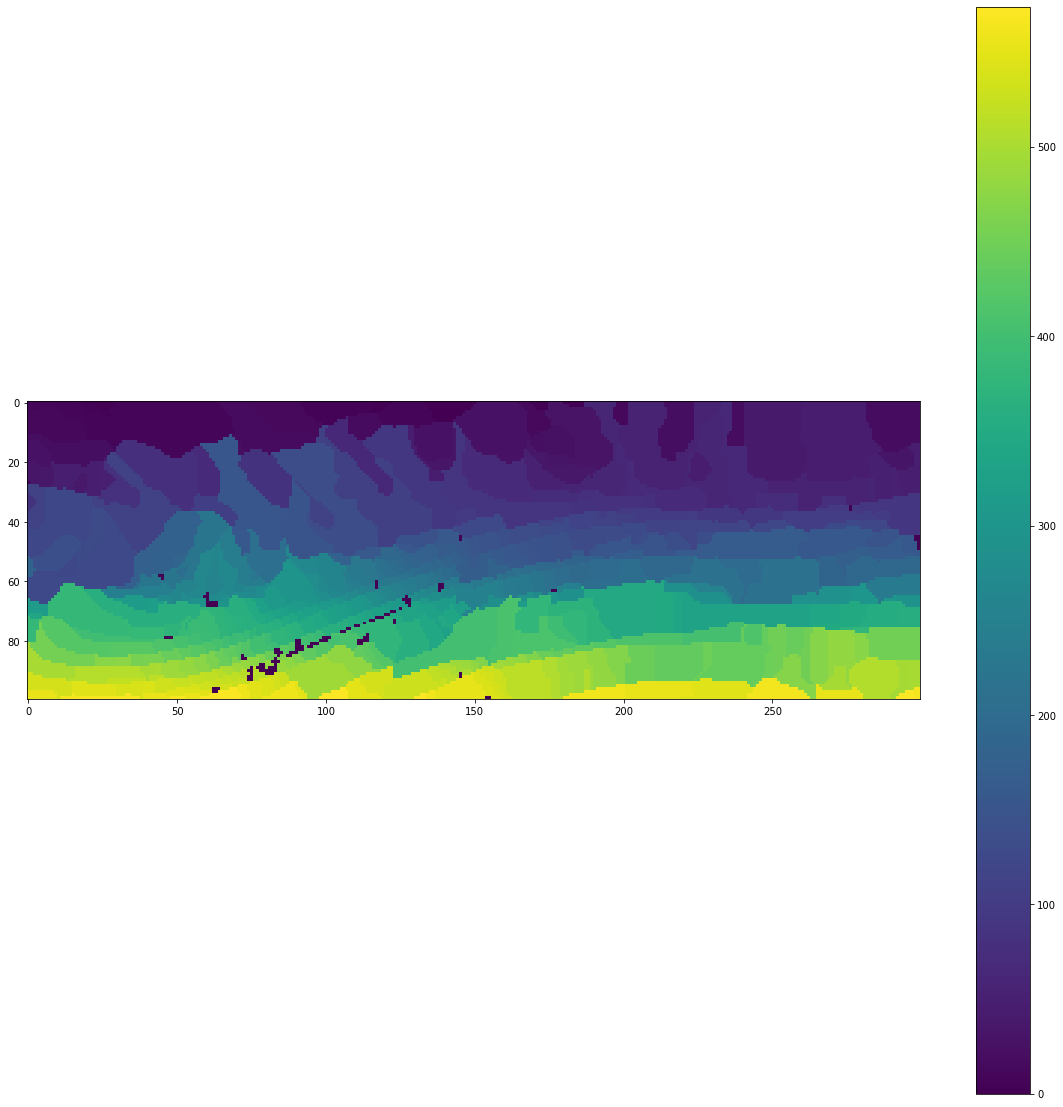

In [89]:
plt.figure(figsize=(20,20))
plt.imshow(DB)
plt.colorbar()

In [19]:
REMA_ds = xr.Dataset(
     {
         "drainage_basin": (
             ("y", "x"),
             DB),
         "depression_depth": (("y", "x"), P_all),
     },
     coords={"x": ds_subset.x, "y": ds_subset.y},
        attrs = ds.attrs
 )

In [20]:
REMA_ds

<xarray.Dataset>
Dimensions:           (x: 300, y: 100)
Coordinates:
    band              int64 1
  * x                 (x) float64 1.72e+06 1.721e+06 ... 1.839e+06 1.84e+06
  * y                 (y) float64 7.398e+05 7.394e+05 ... 7.006e+05 7.002e+05
Data variables:
    drainage_basin    (y, x) int32 748 748 748 748 748 748 ... 61 61 63 63 63 63
    depression_depth  (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    transform:           (8.0, 0.0, 1600000.0, 0.0, -8.0, 800000.0)
    crs:                 +init=epsg:3031
    res:                 (8.0, 8.0)
    is_tiled:            1
    nodatavals:          (-9999.0,)
    scales:              (1.0,)
    offsets:             (0.0,)
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST

# Part 2: Landsat 8 derived surface lake boundaries:

In [1]:
import pandas as pd
import geopandas as gpd
import os, shutil
from glob import glob
import numpy as np
import xarray as xr
import scipy.ndimage
from matplotlib import pyplot as plt
%matplotlib widget
import dask

In [2]:
import shapely
import datetime

In [3]:
cd

/home/jovyan


In [4]:
WRS_PATH = './L8_data/external/Landsat8/WRS2_descending_0.zip'
LANDSAT_PATH = os.path.dirname(WRS_PATH)


!wget -P {LANDSAT_PATH} https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/WRS2_descending_0.zip



In [5]:
shutil.unpack_archive(WRS_PATH, os.path.join(LANDSAT_PATH, 'wrs2'))

In [6]:
wrs = gpd.GeoDataFrame.from_file('L8_data/external/Landsat8/wrs2/WRS2_descending.shp')

In [7]:
ice_shelves = gpd.read_file('L8_data/external/Landsat8/IceShelf_Antarctica_v02.shp')

In [8]:
amery = ice_shelves[ice_shelves['NAME']=='Amery']

In [9]:
amery = amery.to_crs('EPSG:4326')


In [10]:
wrs_intersection  = wrs[wrs.intersects(shapely.geometry.Polygon.from_bounds(float(amery.bounds.minx),
                                                    float(amery.bounds.miny),float(amery.bounds.maxx),float(amery.bounds.maxy)))]

In [11]:
paths, rows = wrs_intersection['PATH'].values, wrs_intersection['ROW'].values

In [12]:
paths

array([125, 125, 125, 125, 132, 132, 132, 123, 123, 123, 130, 130, 130,
       130, 121, 128, 128, 128, 128, 128, 126, 126, 126, 126, 126, 133,
       133, 124, 124, 124, 131, 131, 131, 122, 122, 129, 129, 129, 129,
       129, 127, 127, 127, 127, 127])

In [13]:
s3_scenes = pd.read_csv('http://landsat-pds.s3.amazonaws.com/c1/L8/scene_list.gz', compression='gzip')


In [14]:
s3_scenes.head(3)


,productId,entityId,acquisitionDate,cloudCover,processingLevel,path,row,min_lat,min_lon,max_lat,max_lon,download_url
0,LC08_L1TP_149039_20170411_20170415_01_T1,LC81490392017101LGN00,2017-04-11 05:36:29.349932,0.00,L1TP,149,39,29.22165,72.41205,31.34742,74.84666,https://s3-us-west-2.amazonaws.com/landsat-pds...
1,LC08_L1TP_012001_20170411_20170415_01_T1,LC80120012017101LGN00,2017-04-11 15:14:40.001201,0.15,L1TP,12,1,79.51504,-22.06995,81.90314,-7.44339,https://s3-us-west-2.amazonaws.com/landsat-pds...
2,LC08_L1TP_012002_20170411_20170415_01_T1,LC80120022017101LGN00,2017-04-11 15:15:03.871058,0.38,L1TP,12,2,78.74882,-29.24387,81.14549,-15.04330,https://s3-us-west-2.amazonaws.com/landsat-pds...


In [15]:
b = (paths > 126) & (paths < 128)
paths = paths[b]
rows = rows[b]

In [25]:
# Empty list to add the images
bulk_list = []

# Iterate through paths and rows
for path, row in zip(paths, rows):

    print('Path:',path, 'Row:', row)

    # Filter the Landsat Amazon S3 table for images matching path, row, cloudcover and processing state.
    scenes = s3_scenes[(s3_scenes.path == path) & (s3_scenes.row == row) & 
                       (s3_scenes.cloudCover <= 5)]
    scenes = scenes[scenes.acquisitionDate.str.slice(5,7).astype(int)<2]
    print(' Found {} images\n'.format(len(scenes)))

    # If any scenes exists, select the one that have the minimum cloudCover.
    if len(scenes):
        scene0 = scenes.sort_values('cloudCover').iloc[0]
        scene1 = scenes.sort_values('cloudCover').iloc[1]
        scene2 = scenes.sort_values('cloudCover').iloc[2]

    else:
        continue
    # Add the selected scene to the bulk download list.
    bulk_list.append(scene0)
    bulk_list.append(scene1)
    bulk_list.append(scene2)

Path: 127 Row: 108
 Found 0 images

Path: 127 Row: 109
 Found 4 images

Path: 127 Row: 110
 Found 5 images

Path: 127 Row: 111
 Found 5 images

Path: 127 Row: 112
 Found 5 images



In [26]:
bulk_frame = pd.concat(bulk_list, 1).T
bulk_frame

,productId,entityId,acquisitionDate,cloudCover,processingLevel,path,row,min_lat,min_lon,max_lat,max_lon,download_url
349640,LC08_L1GT_127109_20180114_20180114_01_RT,LC81271092018014LGN00,2018-01-14 03:49:00.905936,0,L1GT,127,109,-70.8375,69.5321,-68.9107,76.6728,https://s3-us-west-2.amazonaws.com/landsat-pds...
1834045,LC08_L1GT_127109_20200120_20200120_01_RT,LC81271092020020LGN00,2020-01-20 03:49:06.527679,0,L1GT,127,109,-70.8369,69.5497,-68.9099,76.6962,https://s3-us-west-2.amazonaws.com/landsat-pds...
1816466,LC08_L1GT_127109_20200104_20200104_01_RT,LC81271092020004LGN00,2020-01-04 03:49:09.747707,0.01,L1GT,127,109,-70.8369,69.5497,-68.9099,76.6962,https://s3-us-west-2.amazonaws.com/landsat-pds...
349641,LC08_L1GT_127110_20180114_20180114_01_RT,LC81271102018014LGN00,2018-01-14 03:49:24.881695,0,L1GT,127,110,-72.1631,67.3456,-70.2626,75.0568,https://s3-us-west-2.amazonaws.com/landsat-pds...
863814,LC08_L1GT_127110_20190117_20190117_01_RT,LC81271102019017LGN00,2019-01-17 03:49:11.035550,0,L1GT,127,110,-72.1631,67.3456,-70.26,75.0589,https://s3-us-west-2.amazonaws.com/landsat-pds...
1834046,LC08_L1GT_127110_20200120_20200120_01_RT,LC81271102020020LGN00,2020-01-20 03:49:30.499203,0,L1GT,127,110,-72.1654,67.3612,-70.2621,75.0819,https://s3-us-west-2.amazonaws.com/landsat-pds...
1834148,LC08_L1GT_127111_20200120_20200120_01_RT,LC81271112020020LGN00,2020-01-20 03:49:54.470726,0.04,L1GT,127,111,-73.4731,64.8826,-71.5983,73.2477,https://s3-us-west-2.amazonaws.com/landsat-pds...
1816468,LC08_L1GT_127111_20200104_20200104_01_RT,LC81271112020004LGN00,2020-01-04 03:49:57.694990,0.05,L1GT,127,111,-73.4731,64.8744,-71.5983,73.2477,https://s3-us-west-2.amazonaws.com/landsat-pds...
863813,LC08_L1GT_127111_20190117_20190117_01_RT,LC81271112019017LGN00,2019-01-17 03:49:35.011309,0.11,L1GT,127,111,-73.4739,64.8623,-71.5967,73.2314,https://s3-us-west-2.amazonaws.com/landsat-pds...
1834149,LC08_L1GT_127112_20200120_20200120_01_RT,LC81271122020020LGN00,2020-01-20 03:50:18.442248,0.14,L1GT,127,112,-74.7588,62.0524,-72.9162,71.1638,https://s3-us-west-2.amazonaws.com/landsat-pds...


conda install bs4

# Import requests and beautiful soup
import requests
from bs4 import BeautifulSoup

# For each row
for i, row in bulk_frame.iterrows():

    # Print some the product ID
    print('\n', 'EntityId:', row.productId, '\n')
    print(' Checking content: ', '\n')

    # Request the html text of the download_url from the amazon server. 
    # download_url example: https://landsat-pds.s3.amazonaws.com/c1/L8/139/045/LC08_L1TP_139045_20170304_20170316_01_T1/index.html
    response = requests.get(row.download_url)

    # If the response status code is fine (200)
    if response.status_code == 200:

        # Import the html to beautiful soup
        html = BeautifulSoup(response.content, 'html.parser')

        # Create the dir where we will put this image files.
        entity_dir = os.path.join(LANDSAT_PATH, row.productId)
        os.makedirs(entity_dir, exist_ok=True)

        # Second loop: for each band of this image that we find using the html <li> tag
        for li in html.find_all('li'):

            # Get the href tag
            file = li.find_next('a').get('href')

            print('  Downloading: {}'.format(file))

            # Download the files
            # code from: https://stackoverflow.com/a/18043472/5361345

            response = requests.get(row.download_url.replace('index.html', file), stream=True)

            with open(os.path.join(entity_dir, file), 'wb') as output:
                shutil.copyfileobj(response.raw, output)
            del response

In [18]:
pi = np.pi
df_index = 1834148
mtl_path = str('L8_data/external/Landsat8/'+bulk_frame.productId[df_index]+'/'+bulk_frame.productId[df_index]+'_MTL.txt')
mtl_var = {}
with open(mtl_path) as MTL:
    for line in MTL:
        name, var = line.partition("=")[::2]
        mtl_var[name.strip()] = var

B2 = xr.open_rasterio(str('L8_data/external/Landsat8/'+bulk_frame.productId[df_index]+'/'+bulk_frame.productId[df_index]+'_B2.TIF'))
B2 = ((np.double(B2)*float(mtl_var['REFLECTANCE_MULT_BAND_2']))+float(mtl_var['REFLECTANCE_ADD_BAND_2'])/np.sin(float(mtl_var['SUN_ELEVATION'])* pi / 180)) * 10000; #DN to TOA reflectance conversion

B3 = xr.open_rasterio(str('L8_data/external/Landsat8/'+bulk_frame.productId[df_index]+'/'+bulk_frame.productId[df_index]+'_B3.TIF'))
B3 = ((np.double(B3)*float(mtl_var['REFLECTANCE_MULT_BAND_3']))+float(mtl_var['REFLECTANCE_ADD_BAND_3'])/np.sin(float(mtl_var['SUN_ELEVATION'])* pi / 180))* 10000; #DN to TOA reflectance conversion

B4 = xr.open_rasterio(str('L8_data/external/Landsat8/'+bulk_frame.productId[df_index]+'/'+bulk_frame.productId[df_index]+'_B4.TIF'))
B4 = ((np.double(B4)*float(mtl_var['REFLECTANCE_MULT_BAND_4']))+float(mtl_var['REFLECTANCE_ADD_BAND_4'])/np.sin(float(mtl_var['SUN_ELEVATION'])* pi / 180))* 10000; #DN to TOA reflectance conversion

B6 = xr.open_rasterio(str('L8_data/external/Landsat8/'+bulk_frame.productId[df_index]+'/'+bulk_frame.productId[df_index]+'_B6.TIF'))
B6 = ((np.double(B6)*float(mtl_var['REFLECTANCE_MULT_BAND_6']))+float(mtl_var['REFLECTANCE_ADD_BAND_6'])/np.sin(float(mtl_var['SUN_ELEVATION'])* pi / 180))* 10000; #DN to TOA reflectance conversion

B10 = xr.open_rasterio(str('L8_data/external/Landsat8/'+bulk_frame.productId[df_index]+'/'+bulk_frame.productId[df_index]+'_B10.TIF'))
B10 = ((np.double(B10)*float(mtl_var['RADIANCE_MULT_BAND_10']))+float(mtl_var['RADIANCE_ADD_BAND_10'])/np.sin(float(mtl_var['SUN_ELEVATION'])* pi / 180))* 10000; #DN to TOA reflectance conversion
B10=  float(mtl_var['K2_CONSTANT_BAND_10'])/np.log((float(mtl_var['K1_CONSTANT_BAND_10'])/B10)+1) * 10;

# Calculation of NDWI
NDWI = (B2-B4)/(B2+B4); # This is NDWI
NDWI = NDWI*1000;


# Calculation of NDSI

NDSI = (B3-B6)/(B3+B6); # This is NDSI
NDSI = NDSI*1000;


# Calculation of TIRS/Blue

TIRS_Blue= B10/B2; #This is TIRS/Blue 
TIRS_Blue = TIRS_Blue*1000;


# Rock outcrop/Seawater Masking
rock_mask = np.zeros(B4.shape);
rock_mask =np.bool_(rock_mask);
index = np.bitwise_and(np.bitwise_and(TIRS_Blue > 6500, B4 > 0), B2 <3500)
rock_mask[index]=True;  #B4 filtering --> to avoid including image borders
#rock_mask = ~rock_mask

# Cloud Masking
cloud_mask = np.zeros(B4.shape);
cloud_mask = np.bool_(cloud_mask);
index = np.bitwise_and(np.bitwise_and(B6 > 1000 , NDSI < 8000),np.bitwise_and(B2 >6000 , B2 < 9500))
cloud_mask[index] = True;


# Lake Masking
lake_mask = np.zeros(B4.shape);
lake_mask = np.bool_(lake_mask);
index = np.bitwise_and(np.bitwise_and(NDWI > 1900 ,(B3-B4)> 700), (B2-B3)>700)
lake_mask = index[0]; 
lake_mask[rock_mask[0]]=False;
lake_mask[cloud_mask[0]]=False;
lake_mask = lake_mask.squeeze()
#del B2, B3, B4, B6, B10, NDWI, NDSI, TIRS_Blue


In [19]:

plt.figure()
plt.imshow(lake_mask)
plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [24]:
np.count_nonzero(lake_mask)

0

In [39]:
Lake_Mask = xr.Dataset(
{
    "lake_mask":(
    ('y','x'),
    lake_mask)
}, coords = {'x': B4.x.values, 'y': B4.y.values},
attrs   = B4.attrs)

In [40]:
Lake_Mask

<xarray.Dataset>
Dimensions:    (x: 7291, y: 7381)
Coordinates:
  * x          (x) float64 1.712e+06 1.712e+06 1.712e+06 ... 1.93e+06 1.930e+06
  * y          (y) float64 8.025e+05 8.025e+05 8.024e+05 ... 5.811e+05 5.811e+05
Data variables:
    lake_mask  (y, x) bool False False False False ... False False False False
Attributes:
    transform:      (30.0, 0.0, 1711785.0, 0.0, -30.0, 802515.0)
    crs:            +init=epsg:3031
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Point

# Part 3: Combine the two xarray DataSets and calculate statistics of how they match up

In [41]:
REMA_bounds = np.array([[REMA_ds.x.min(), REMA_ds.x.max(), REMA_ds.x.max(),REMA_ds.x.min()],[REMA_ds.y.min(),REMA_ds.y.min(),REMA_ds.y.max(),REMA_ds.y.max()]])
L8_bounds = np.array([[Lake_Mask.x.min(), Lake_Mask.x.max(), Lake_Mask.x.max(),Lake_Mask.x.min()],[Lake_Mask.y.min(),Lake_Mask.y.min(),Lake_Mask.y.max(),Lake_Mask.y.max()]])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

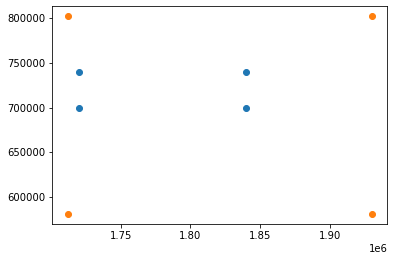

In [42]:
plt.figure()
plt.scatter(REMA_bounds[0],REMA_bounds[1])
plt.scatter(L8_bounds[0],L8_bounds[1])

In [43]:
LakeData = xr.merge((REMA_ds,Lake_Mask.lake_mask.astype(int).interp_like(REMA_ds)))

In [44]:
LakeData = LakeData.assign(REMALake = LakeData.depression_depth>0)

In [45]:
overlap = float((np.bool_(LakeData.lake_mask) & LakeData.REMALake).sum())
rema_basins  = float(LakeData.REMALake.sum())
L8_lakes  = float((LakeData.lake_mask>0).sum())

In [45]:
overlap/(rema_basins-overlap)

0.0019828155981493722

In [110]:
overlap/(L8_lakes)

0.6

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

([<matplotlib.patches.Wedge at 0x7f9f431f07d0>,
 [Text(-0.33991877217145816, 1.046162142464278, ''),
  Text(0.3399188701202255, -1.046162110638781, '')])

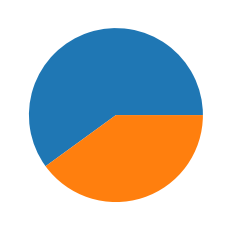

In [111]:
plt.pie([overlap,L8_lakes-overlap])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

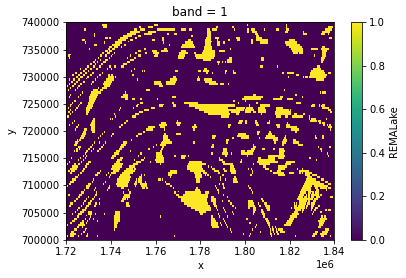

In [113]:
LakeData.REMALake.plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

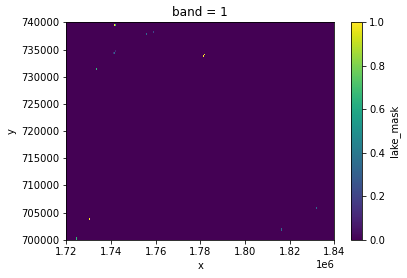

In [114]:
LakeData.lake_mask.plot()

In [53]:
%matplotlib widget
B4.coarsen(x=23).mean().plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …